# CNN from scratch 

In this section a Convolutional Neural Network is trained from scratch analysing the critical aspects and situations encountered during implementation.

The approach adopted is the following: at first, a simple model is built and trained on the training set; after the validation set is used to see generalization capabilities and analysing underfitting /overfitting situations; finally, the test set is used to see the accuracy score on the unseen data. If an underfitting situation occurs, the model is gradually increased in complexity in order to have a higher accuracy. If an overfitting situation occurs, the model is regularized with some techniques in order to reduce this phenomenon. Before building each model, a proper set of hyperparameters is chosen. An analysis of the error is done in order to understand if the errors obtained are common or if the networks have different predictive power.

##Set parameters and load data

In [1]:
#Import all the required libraries

import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

from google.colab import drive

In [2]:
# Mount drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Set parameters

#Paths to get the splitted dataset
BASE_PATH='/content/drive/MyDrive/Vigna/'
DATASET_FOLDER_NAME='dataset'

NEW_PATH=os.path.join(BASE_PATH,DATASET_FOLDER_NAME)
NEW_PATH_TRAIN=os.path.join(NEW_PATH,'train')
NEW_PATH_VALIDATION=os.path.join(NEW_PATH,'validation')
NEW_PATH_TEST=os.path.join(NEW_PATH,'test')

MODEL_PATH=os.path.join(BASE_PATH,'models')
HISTORY_PATH=os.path.join(MODEL_PATH,'history')

#Hyperparameters
BATCH_SIZE=32
EPOCHS=50
PATIENCE=5

In [8]:
#Creating models and history directories
if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(HISTORY_PATH):
  os.makedirs(HISTORY_PATH)

In [4]:
#Some utility functions

#Create a simple callback used during training process

#Used only in exp1
def createCustomCallbackExp1(save_path,val_to_monitor):
  return [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=val_to_monitor,
    verbose=1,
    restore_best_weights=True,
    save_best_only=True #Save best model only
    )
  ]

#Used in all other experiments
def createCustomCallbackExpGen(save_path,val_to_monitor,patience):
  return [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=val_to_monitor,
    verbose=1,
    patience=patience,
    restore_best_weights=True,
    save_best_only=True #Save best model only
    ),
    keras.callbacks.EarlyStopping(monitor=val_to_monitor, patience=patience)
  ]



#Function to plot custom graphics to see training performance
#xTra_scale range of values on x - training
#yTra_scale range of values on y - training
#xVal_scale range of values on x - validation
#yVal_scale range of values on y - validation
def plotAccuracyAndLossCurves(history,xTra_scale=np.arange(1, EPOCHS+1, 1),yTra_scale=np.arange(0, 1+0.05, 0.05),xVal_scale=np.arange(1, EPOCHS+1, 1),yVal_scale=np.arange(0, 1, 0.05)):
  plt.figure(figsize=(15,5))
  
  #On training set
  acc_1 = history['accuracy']
  loss_1 = history['loss']
  
  #On validation set
  val_acc_1 = history['val_accuracy']
  val_loss_1 = history['val_loss']

  #History length
  n_epochs=len(historySaved['accuracy'])
  
  epochs = np.arange(1, n_epochs+1, 1)
  plt.grid()
  plt.plot(epochs, acc_1, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc_1, 'r-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.xticks(xTra_scale)
  plt.yticks(yTra_scale)
  plt.figure()

  plt.figure(figsize=(15,5))
  plt.plot(epochs, loss_1, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_1, 'r-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xticks(xVal_scale)
  plt.yticks(yVal_scale)
  plt.legend()
  plt.grid()

  plt.show()


#Function to plot a custom barchar
def drawBarPlot(plt,name,values,title):
  plt.figure(figsize=(15, 5))
  plt.bar(name, values, width = 0.2, color='blue')
  plt.xlabel("Classes misclassified")
  plt.ylabel("No. of misclassification ")
  plt.title(title)
  plt.show()

#Function to have a brief summary of classification error on test dataset
def statErrors(test_dataset,predictions,verbose=False,displayImage=False):
  errorCount=0
  indexErr_List=[]
  
  #Iterate on all the test dataset
  test_val=tf.concat([data_batch for data_batch, labels_batch in test_dataset], axis = 0)
  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  

  class_names = test_dataset.class_names

  #Print the status of correct/incorrect predictions.
  if (verbose==True):
      print("predicted || actual");

  map={}
  for i in range (len(class_names)):
    map[class_names[i]]=0

  for indexTest in range(predictions.shape[0]):
      infoStr="";
      actual=class_names[np.argmax(y_test[indexTest])]
      predicted=class_names[np.argmax(predictions[indexTest])]
      if (np.argmax(predictions[indexTest])!=np.argmax(y_test[indexTest])):
          errorCount+=1;
          indexErr_List.append(indexTest)
          infoStr="ERROR ";
          classToMatch=class_names[np.argmax(y_test[indexTest])]
          if classToMatch in map:
            map[classToMatch]=map[classToMatch]+1
         
      if (verbose==True):
        print(str(indexTest)+") "+infoStr+" "+predicted+'||'+actual+": "+str((predictions[indexTest][np.argmax(predictions[indexTest])])*100)+"%");
 
  print ("Total errors :" +str(errorCount)+"/"+str(predictions.shape[0]));

  drawBarPlot(plt,map.keys(),map.values(),'Misclassifications per class')

  IMAGE_PER_RAW=6
  if (displayImage):
    plt.figure(figsize=(20, 10))
    class_names = test_dataset.class_names
    for i in range(len(indexErr_List)):
        index=indexErr_List[i]
        ax = plt.subplot(int(len(indexErr_List)/IMAGE_PER_RAW)+1, IMAGE_PER_RAW, i + 1)
        plt.imshow(test_val[index][:,:,0], cmap='gray')  
        
        perc=round ( (predictions[index][np.argmax(predictions[index])])*100,2)
        percStr=str(perc)+"%"

        plt.title("Pred. "+class_names[np.argmax(predictions[index])]+" conf: "+percStr ,  fontsize=10)
        plt.text(0,600, "Act. "+class_names[np.argmax(y_test[index])], fontSize=12,bbox=dict(facecolor='red', alpha=0.2));
        
        plt.axis("off")

#Plot the confusion matrix and the ROC curve
def evalutation_performance(test_dataset,predictions,ystart):

  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  
  
  y_testEFF=np.argmax(y_test, axis=1)
  y_pred = np.argmax(predictions, axis=1)

  cm = confusion_matrix(y_testEFF, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)

  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title('Confusion Matrix');
  #font = {
  #        'weight' : 'bold',
  #        'size'   : 10}

  #plt.rc('font', **font)

  disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='g')
  plt.show()

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(test_dataset.class_names)):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','red','brown','pink','green','violet'])
  for i, color in zip(range(len(test_dataset.class_names)), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=2,
          label='ROC curve of class '+str(test_dataset.class_names[i])+' (area = {1:0.4f})'.format(i, roc_auc[i]),
          
      )

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multiclass')
  plt.legend(loc='lower right',prop={'size': 8})
  plt.show()

  plt.figure(2)
  plt.xlim(0, 0.1)
  plt.ylim(ystart, 1.02)
  plt.plot([0, 1], [0, 1], 'k--')

  for i, color in zip(range(len(test_dataset.class_names)), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=2,
          label='ROC curve of class '+str(test_dataset.class_names[i]),    
  )

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve (zoomed in at top left)')
  plt.legend(loc='lower right',prop={'size': 8})
  plt.show()


In [ ]:
#Load data
train_dataset = image_dataset_from_directory(
    NEW_PATH_TRAIN,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
    )

validation_dataset = image_dataset_from_directory(
    NEW_PATH_VALIDATION,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
    )

test_dataset = image_dataset_from_directory(
    NEW_PATH_TEST,
    labels='inferred',
    shuffle=False,
    label_mode='categorical',
    image_size=(480, 640),
    color_mode='grayscale',
    batch_size=BATCH_SIZE)

Found 3150 files belonging to 9 classes.
Found 675 files belonging to 9 classes.
Found 675 files belonging to 9 classes.


## Experiment 1: simple model
In this first experiment a simple model is used in order to do some observations and to have an idea of the behaviour of different optimizers during the training process. 
The model used has the following structure:

In [ ]:
#Define model structure
def createModelExp1():
  inputs = keras.Input(shape=(480, 640, 1))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu",padding="same")(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",padding="same")(x)

  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Flatten()(x)

  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

### RMS-Prop

The first optimizer used is RMS-Prop (Root Mean Square Propagation): the learning rate is an exponential average of the gradients instead of the cumulative sum of squared gradients. 

In [ ]:
#Istantiate the model
model=createModelExp1()

#Define a callback
custom_callback=createCustomCallbackExp1(os.path.join(MODEL_PATH, 'firstCNNModel_1.h5'),'val_loss')

#Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 480, 640, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 480, 640, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                         

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history1_1Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.9166 - accuracy: 0.7115
Epoch 1: val_loss improved from inf to 0.86788, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_1.h5
99/99 [==============================] - 344s 3s/step - loss: 0.9166 - accuracy: 0.7115 - val_loss: 0.8679 - val_accuracy: 0.6207
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9064
Epoch 2: val_loss improved from 0.86788 to 0.21061, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_1.h5
99/99 [==============================] - 18s 177ms/step - loss: 0.2722 - accuracy: 0.9064 - val_loss: 0.2106 - val_accuracy: 0.9215
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9457
Epoch 3: val_loss improved from 0.21061 to 0.10169, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_1.h5
99/99 [==============================] - 19s 181ms/step - loss: 0.1501 - accuracy: 0.9457 - va

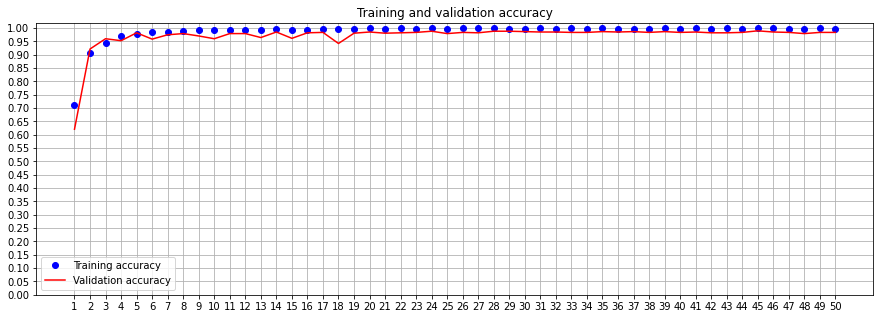

<Figure size 432x288 with 0 Axes>

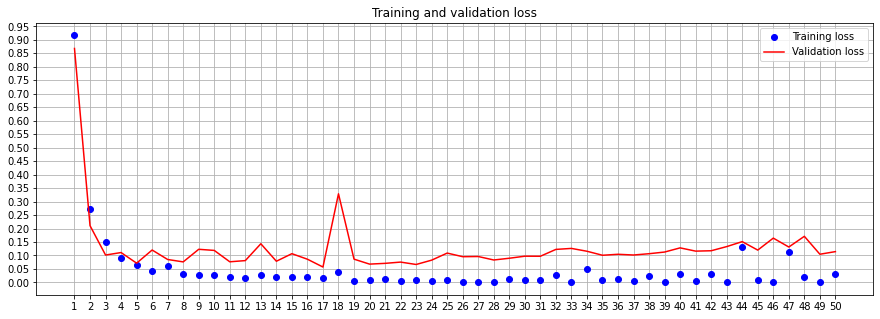

In [9]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history1_1Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
    
plotAccuracyAndLossCurves(historySaved)

In [ ]:
#Load the best model obtained with low loss epoch 17
model1 = load_model(MODEL_PATH+"/firstCNNModel_1.h5") 
predictions = model1.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model1.evaluate(test_dataset)

22/22 [==============================] - 2s 90ms/step - loss: 0.0797 - accuracy: 0.9837


Total errors :11/675


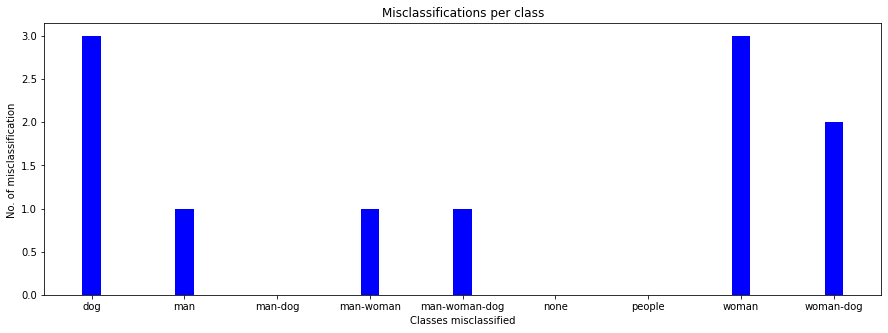

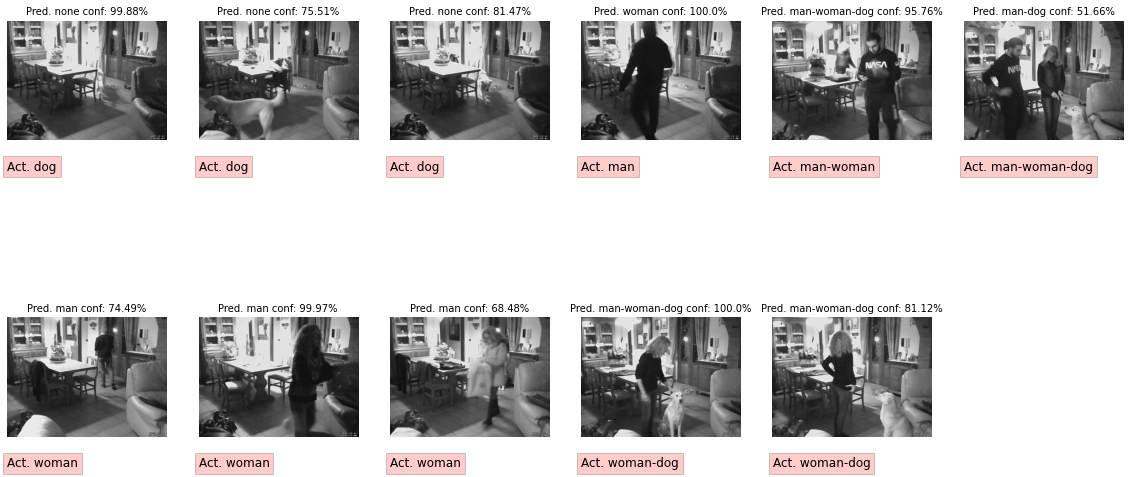

In [ ]:
statErrors(test_dataset,predictions,False,True)

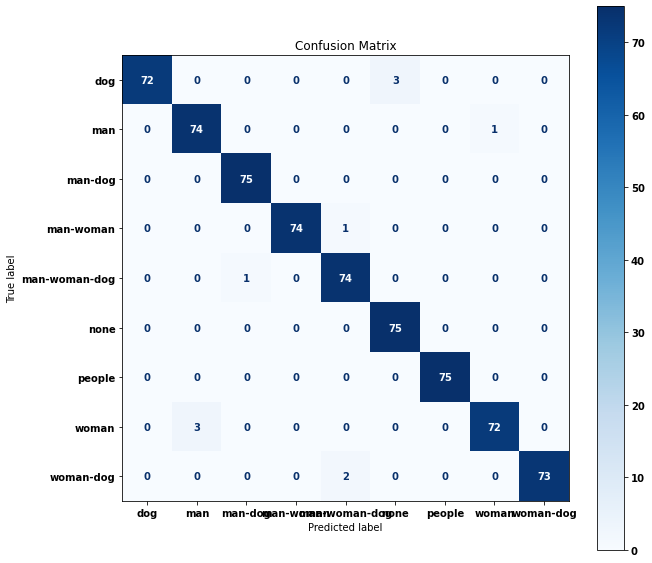

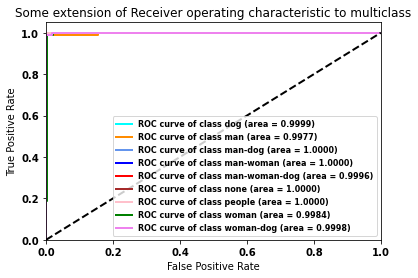

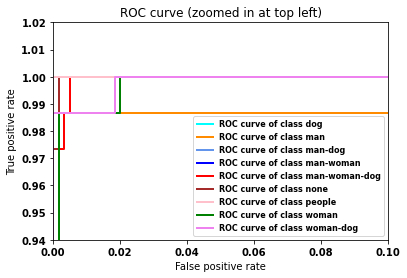

In [ ]:
evalutation_performance(test_dataset,predictions,0.94)

### AdaGrad

The second optimizer used is AdaGrad(Adaptive Gradient Descent): it adapts the learning rate to the parameters performing small updates for frequently occurring features and large updates for the rarest ones. AdaGrad keeps track of the sum of gradient squared and uses that to adapt the gradient in different directions. This is useful when features are very sparse. The average gradient for sparse features is usually small so such features get trained at a much slower rate. 

In [ ]:
#Istantiate the model
model=createModelExp1()

#Define a callback
custom_callback=createCustomCallbackExp1(os.path.join(MODEL_PATH, 'firstCNNModel_2.h5'),'val_loss',PATIENCE)

#Compile the model
model.compile(optimizer='AdaGrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Start training 
history2 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks = custom_callback
)

#Save history obtained in history folder
with open(HISTORY_PATH+'/history1_2Dict', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 2.0114 - accuracy: 0.3459
Epoch 1: val_loss improved from inf to 1.71350, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_3.h5
99/99 [==============================] - 19s 176ms/step - loss: 2.0114 - accuracy: 0.3459 - val_loss: 1.7135 - val_accuracy: 0.5378
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.5950
Epoch 2: val_loss improved from 1.71350 to 1.06198, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_3.h5
99/99 [==============================] - 18s 177ms/step - loss: 1.3875 - accuracy: 0.5950 - val_loss: 1.0620 - val_accuracy: 0.6874
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.7137
Epoch 3: val_loss improved from 1.06198 to 0.84910, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_3.h5
99/99 [==============================] - 18s 178ms/step - loss: 0.9227 - accuracy: 0.7137 - 

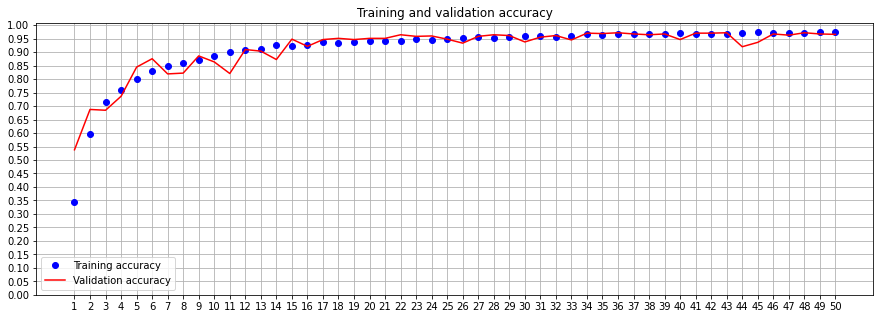

<Figure size 432x288 with 0 Axes>

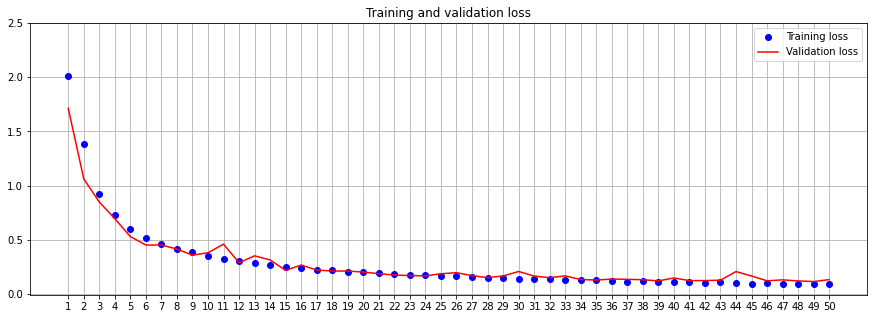

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history1_2Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 3, 0.5))

In [ ]:
#Load the best model obtained with low loss at epoch 49
model2 = load_model(MODEL_PATH+"/firstCNNModel_2.h5") 
predictions = model2.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model2.evaluate(test_dataset)

22/22 [==============================] - 39s 2s/step - loss: 0.1469 - accuracy: 0.9541


Total errors :31/675


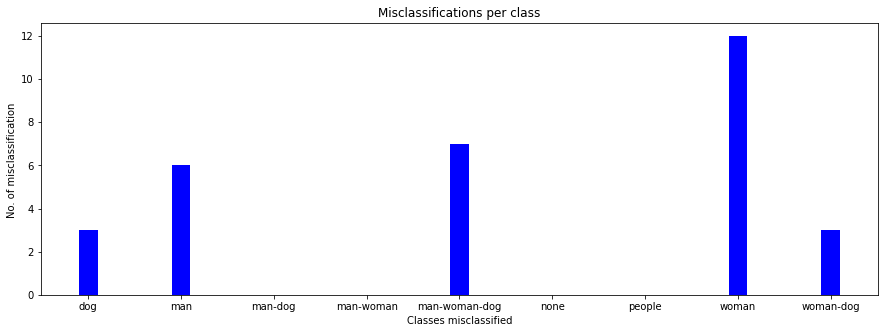

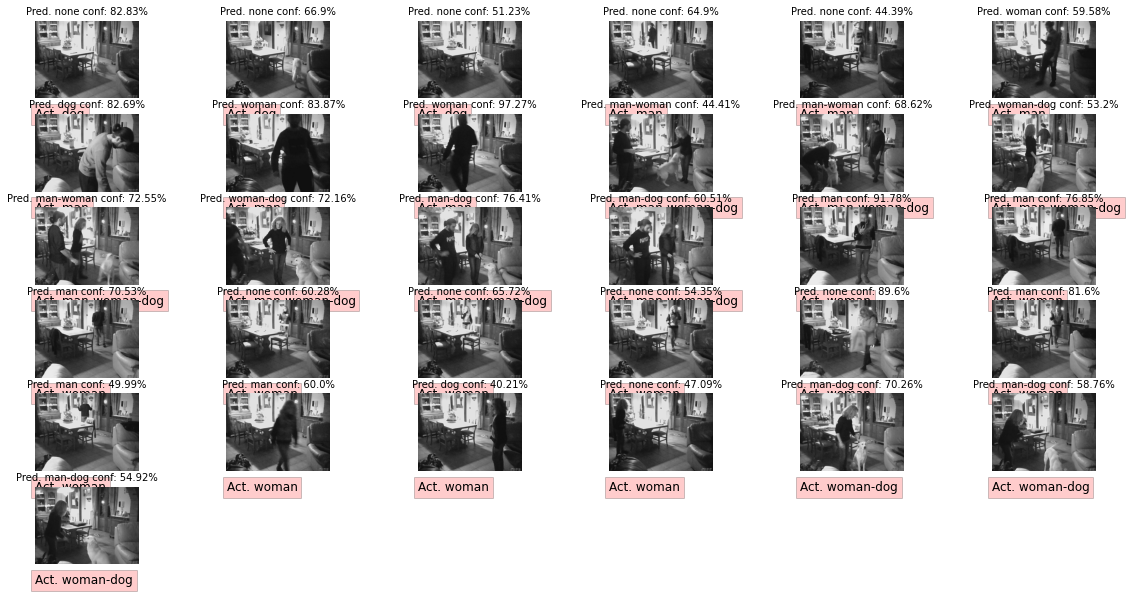

In [ ]:
statErrors(test_dataset,predictions,False,True)

### Adam

The second optimizer used is Adam (Adaptive Moment Estimation): it is a method that computes adaptive learning rates for each parameter. It stores both the decaying average of the past gradients , similar to momentum and also the decaying average of the past squared gradients , similar to RMS-Prop and AdaGrad. Thus, it combines the advantages of both the methods.  

In [ ]:
#Istantiate the model
model=createModelExp1()

#Define a callback
custom_callback=createCustomCallbackExp1(os.path.join(MODEL_PATH, 'firstCNNModel_3.h5'),'val_loss')

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 480, 640, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 480, 640, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 160, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                       

In [ ]:
#Start training 
history3 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks = custom_callback
)

#Save history obtained in history folder
with open(HISTORY_PATH+'/history1_3Dict', 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.7179
Epoch 1: val_loss improved from inf to 0.29290, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_2.h5
99/99 [==============================] - 19s 186ms/step - loss: 0.7717 - accuracy: 0.7179 - val_loss: 0.2929 - val_accuracy: 0.8919
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9356
Epoch 2: val_loss improved from 0.29290 to 0.11230, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_2.h5
99/99 [==============================] - 18s 179ms/step - loss: 0.1918 - accuracy: 0.9356 - val_loss: 0.1123 - val_accuracy: 0.9748
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9692
Epoch 3: val_loss improved from 0.11230 to 0.09192, saving model to /content/drive/MyDrive/CIDL/models/firstCNNModel_2.h5
99/99 [==============================] - 18s 178ms/step - loss: 0.0987 - accuracy: 0.9692 - 

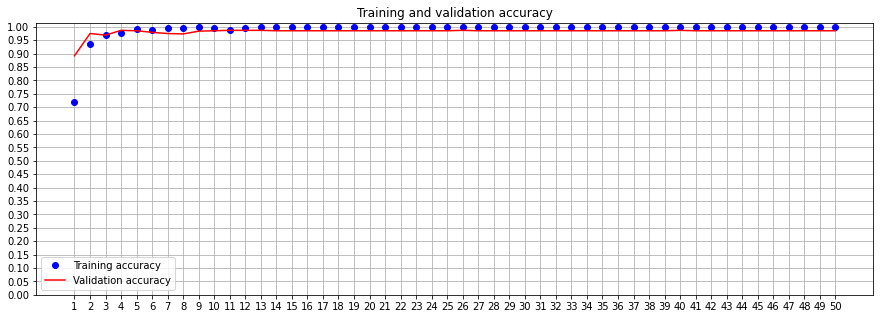

<Figure size 432x288 with 0 Axes>

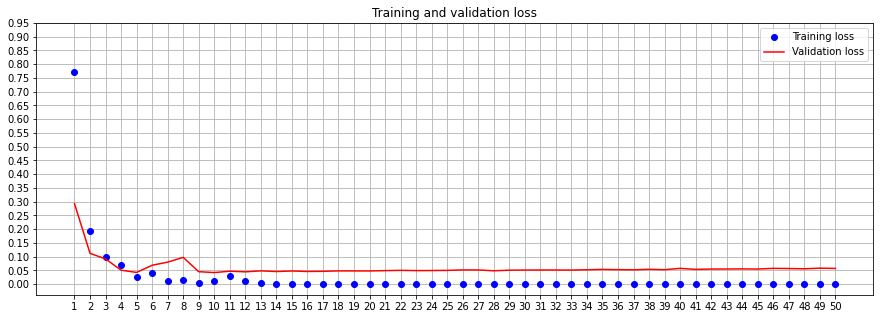

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history1_3Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved)

In [ ]:
#Load the best obtained with low loss epoch 10
model3 = load_model(MODEL_PATH+"/firstCNNModel_3.h5") 
predictions = model3.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model3.evaluate(test_dataset)

22/22 [==============================] - 37s 2s/step - loss: 0.0725 - accuracy: 0.9778


Total errors :15/675


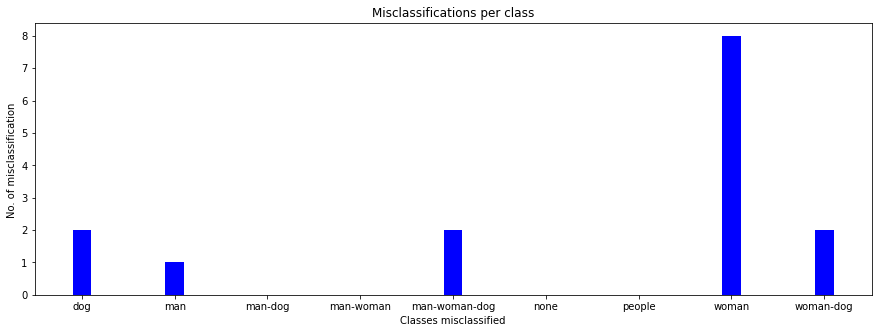

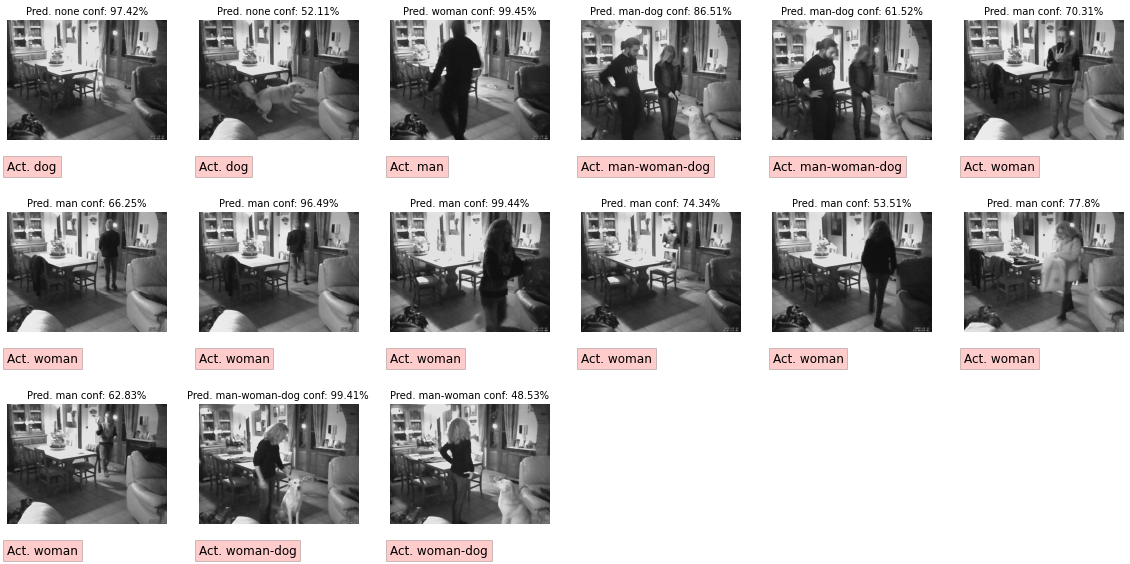

In [ ]:
statErrors(test_dataset,predictions,False,True)

##Experiment 2: deeper model
In this section different deeper models have been considered in order to try to improve as possible the very good result obtained so far. In all the further experiments, it is used is Adam optimizer. It is also used the early stopping  regularization in order to stop training in overfitting situations if occurs.

### Increase the number of filters
The model used in this first attempt has the same structure of the previous model with the different of a greater number of convolutional filters. In fact, for each convolutional layer the number of filters has been doubled. 
The activation function used  here is LeakyRelu with a value of alpha equal to 0.5. 

In [ ]:
#Define model structure experiment 2_1
def createModelExp2_1():
  inputs = keras.Input(shape=(480, 640, 1))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=64, kernel_size=3,padding="same")(x)
  x = layers.LeakyReLU(alpha=0.5)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=128, kernel_size=3,padding="same")(x)
  x = layers.LeakyReLU(alpha=0.5)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Flatten()(x)
  
  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

In [ ]:
#Istantiate the model
model=createModelExp2_1()

#Define a callback
custom_callback=createCustomCallbackExpGen(os.path.join(MODEL_PATH, 'secondCNNModel_1.h5'),'val_loss',PATIENCE)

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 480, 640, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 480, 640, 64)      640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 480, 640, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 120, 160, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 160, 128)     73856     
                                                           

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks = custom_callback
)

#Save history obtained in history folder
with open(HISTORY_PATH+'/history2_1Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.6962
Epoch 1: val_loss improved from inf to 0.35342, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_a.h5
99/99 [==============================] - 468s 4s/step - loss: 0.9205 - accuracy: 0.6962 - val_loss: 0.3534 - val_accuracy: 0.8667
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8984
Epoch 2: val_loss improved from 0.35342 to 0.15596, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_a.h5
99/99 [==============================] - 35s 352ms/step - loss: 0.2790 - accuracy: 0.8984 - val_loss: 0.1560 - val_accuracy: 0.9600
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9524
Epoch 3: val_loss improved from 0.15596 to 0.12399, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_a.h5
99/99 [==============================] - 35s 351ms/step - loss: 0.1386 - accuracy: 0.9524 -

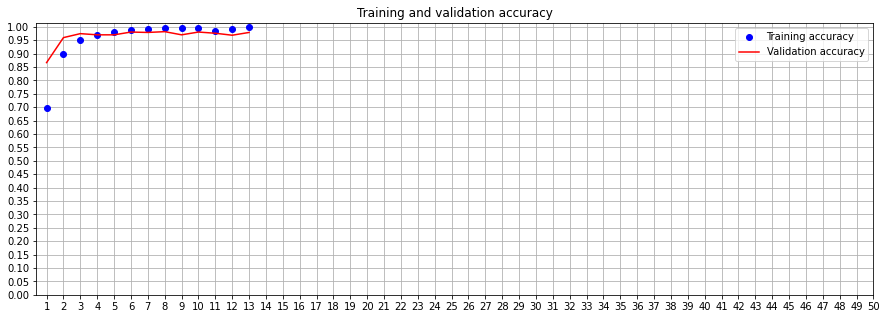

<Figure size 432x288 with 0 Axes>

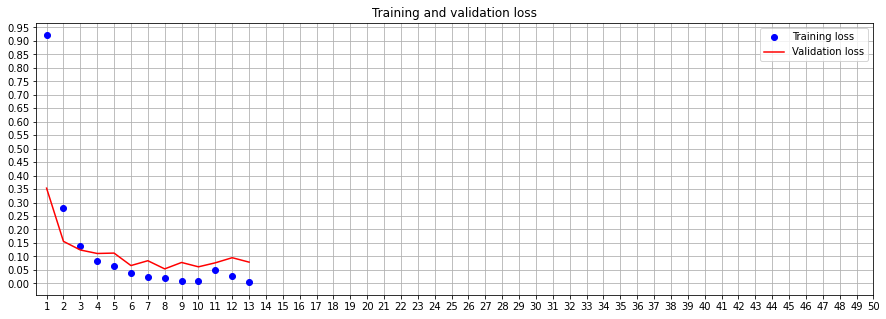

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history2_1Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved)

In [ ]:
#Load the best obtained with low loss epoch 8
model = load_model(MODEL_PATH+"/secondCNNModel_a.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 4s 152ms/step - loss: 0.0822 - accuracy: 0.9778


Total errors :15/675


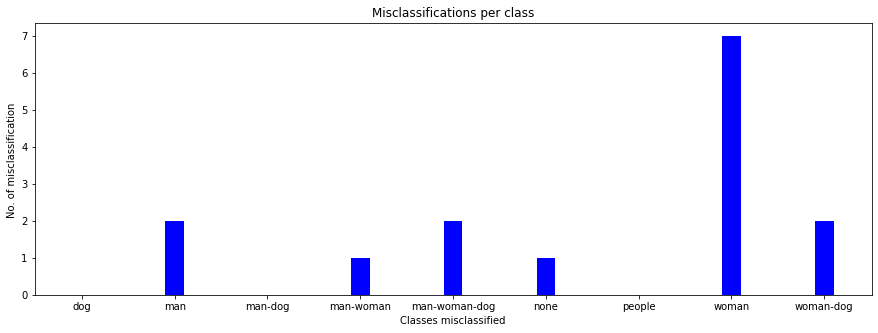

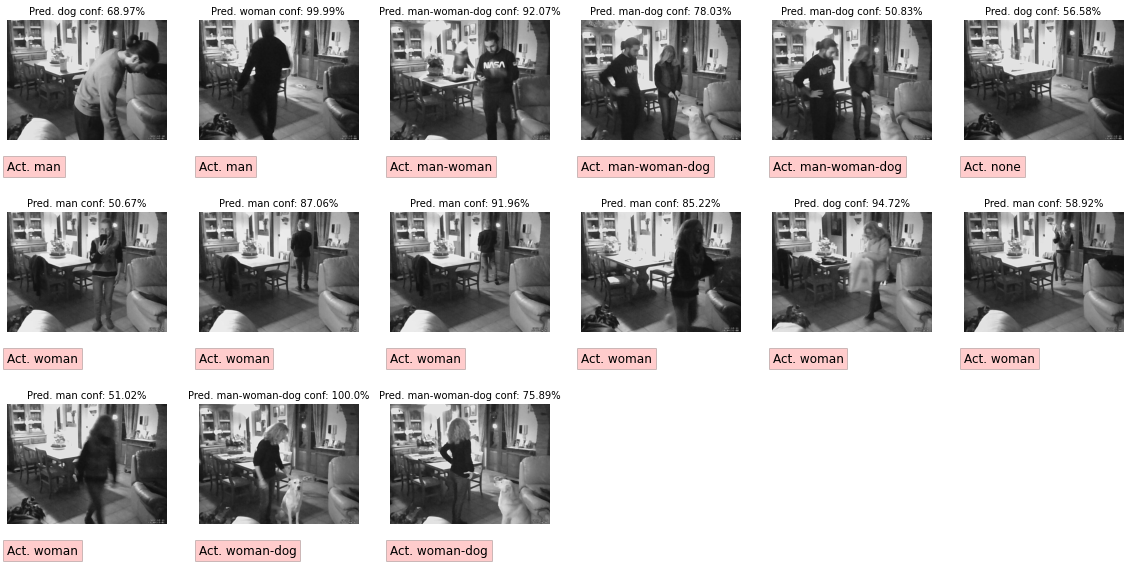

In [ ]:
statErrors(test_dataset,predictions,False,True)

### Add a convolutional layer
The model used in this second attempt has an additional convolutional layer. The first two convolutional layers has the same identical structure and number of filters as the network trained in simple model section with the difference of using a LeakyReLU as activation function. 

In [ ]:
#Define model structure experiment 2_2
def createModelExp2_2():
  inputs = keras.Input(shape=(480, 640, 1))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=32, kernel_size=3,padding="same")(x)
  x = layers.LeakyReLU(alpha=0.5)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=64, kernel_size=3,padding="same")(x)
  x = layers.LeakyReLU(alpha=0.5)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=128, kernel_size=3,padding="same")(x)
  x = layers.LeakyReLU(alpha=0.5)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  
  x = layers.Flatten()(x)

  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

In [ ]:
#Istantiate the model
model=createModelExp2_2()

#Define a callback
custom_callback=createCustomCallbackExpGen(os.path.join(MODEL_PATH, 'secondCNNModel_2.h5'),'val_loss',PATIENCE)

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 480, 640, 1)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 480, 640, 32)      320       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 480, 640, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 160, 64)      18496     
                                                           

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history2_2Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.8880 - accuracy: 0.6825
Epoch 1: val_loss improved from inf to 0.32607, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_1.h5
99/99 [==============================] - 345s 3s/step - loss: 0.8880 - accuracy: 0.6825 - val_loss: 0.3261 - val_accuracy: 0.8963
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9210
Epoch 2: val_loss improved from 0.32607 to 0.18249, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_1.h5
99/99 [==============================] - 20s 196ms/step - loss: 0.2316 - accuracy: 0.9210 - val_loss: 0.1825 - val_accuracy: 0.9452
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9663
Epoch 3: val_loss improved from 0.18249 to 0.10403, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_1.h5
99/99 [==============================] - 20s 193ms/step - loss: 0.1110 - accuracy: 0.9663 -

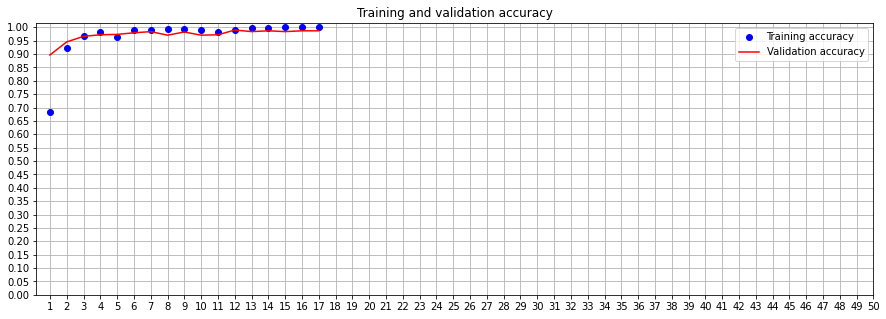

<Figure size 432x288 with 0 Axes>

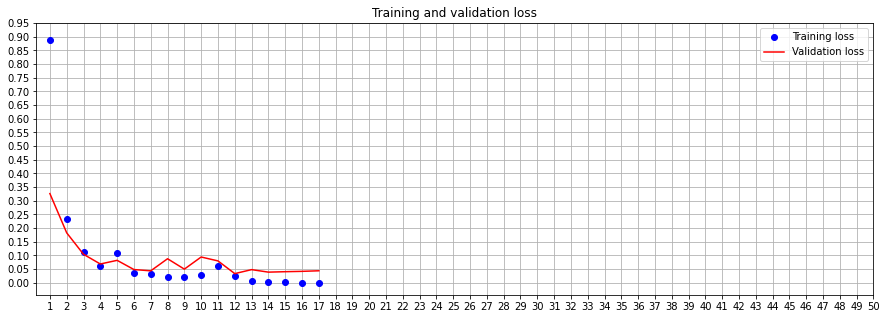

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history2_2Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved)

In [ ]:
#Load the best obtained with low loss epoch 12
model = load_model(MODEL_PATH+"/secondCNNModel_2.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 3s 105ms/step - loss: 0.0689 - accuracy: 0.9822


Total errors :12/675


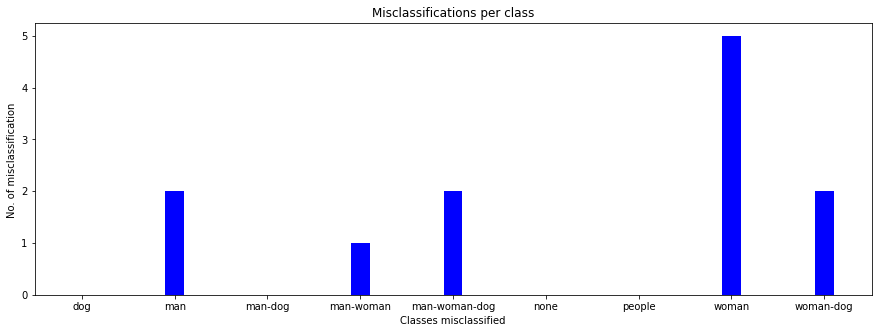

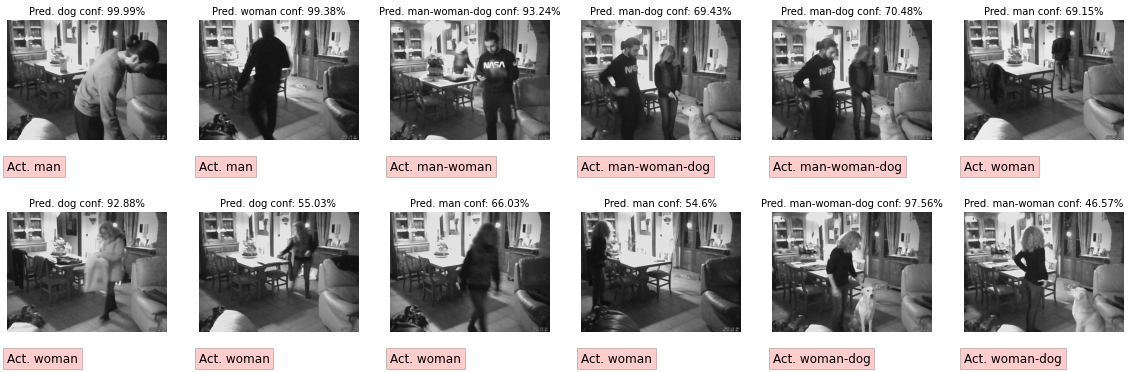

In [ ]:
statErrors(test_dataset,predictions,False,True)

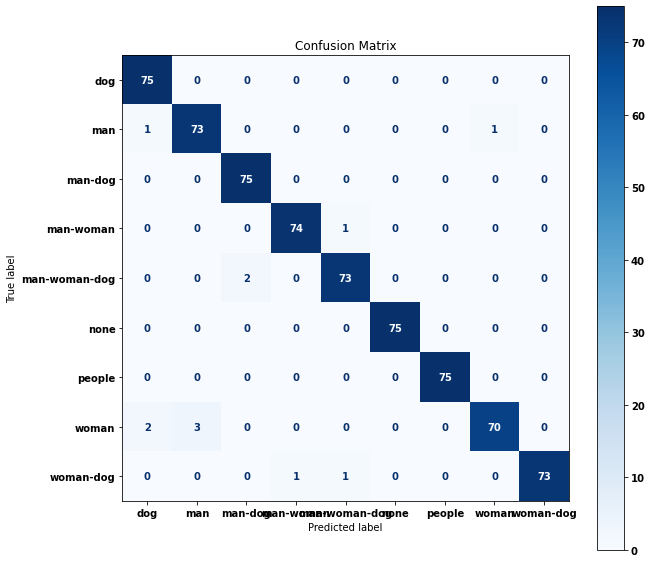

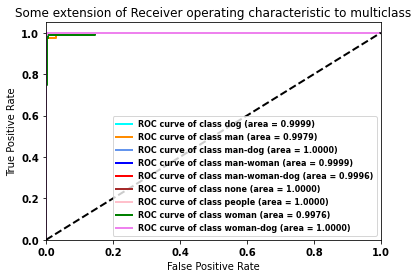

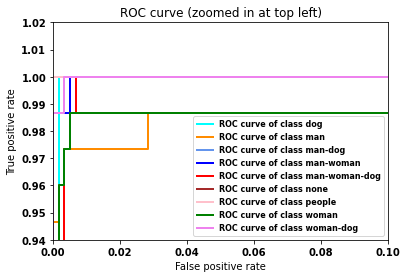

In [ ]:
evalutation_performance(test_dataset,predictions,0.94)

### Relu6
In the last attempt, the same model is used with the ReLU6 activation function instead of LeakyRelu. -	ReLU6, this is another variant of classical ReLU that solves the exploding gradient problem. It restricts to the value 6 on the positive side. Any input value which is 6 or greater than 6 will be restricted to the value 6 (hence the name). In comparison with classical ReLU, ReLU6 activation functions have shown to empirically perform better under low-precision conditions (e.g., fixed point inference) by encouraging the model to learn sparse features earlier. 

In [ ]:
#Define model structure experiment 2_3
def createModelExp2_3():
  inputs = keras.Input(shape=(480, 640, 1))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=32, kernel_size=3,padding="same")(x)
  x = tf.nn.relu6(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=64, kernel_size=3,padding="same")(x)
  x = tf.nn.relu6(x)
  x = layers.MaxPooling2D(pool_size=4)(x)

  x = layers.Conv2D(filters=128, kernel_size=3,padding="same")(x)
  x = tf.nn.relu6(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  
  x = layers.Flatten()(x)

  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

In [ ]:
#Istantiate the model
model=createModelExp2_3()

#Define a callback
custom_callback=createCustomCallbackExpGen(os.path.join(MODEL_PATH, 'secondCNNModel_3.h5'),'val_loss',PATIENCE)

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 480, 640, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 480, 640, 32)      320       
                                                                 
 tf.nn.relu6 (TFOpLambda)    (None, 480, 640, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 64)      18496     
                                                             

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history2_3Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.6178
Epoch 1: val_loss improved from inf to 0.25099, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_3.h5
99/99 [==============================] - 436s 4s/step - loss: 1.0294 - accuracy: 0.6178 - val_loss: 0.2510 - val_accuracy: 0.9348
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9263
Epoch 2: val_loss improved from 0.25099 to 0.16311, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_3.h5
99/99 [==============================] - 19s 187ms/step - loss: 0.2258 - accuracy: 0.9263 - val_loss: 0.1631 - val_accuracy: 0.9570
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9578
Epoch 3: val_loss improved from 0.16311 to 0.08510, saving model to /content/drive/MyDrive/CIDL/models/secondCNNModel_3.h5
99/99 [==============================] - 19s 191ms/step - loss: 0.1327 - accuracy: 0.9578 -

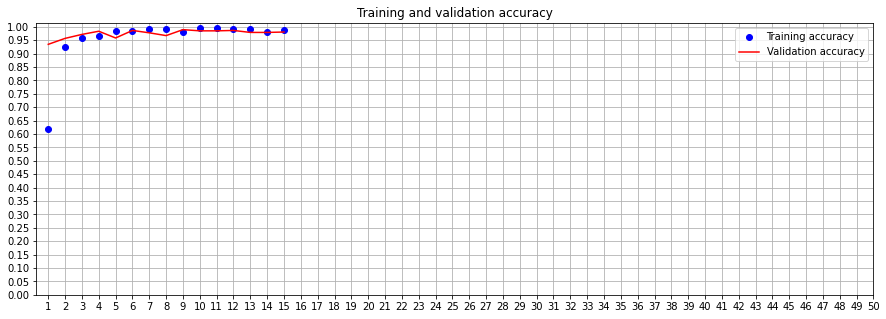

<Figure size 432x288 with 0 Axes>

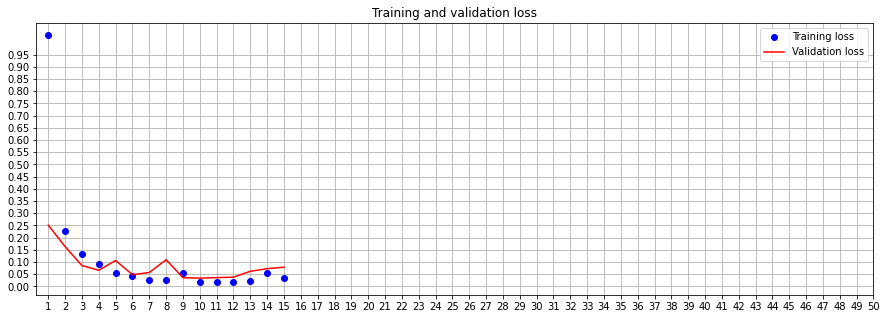

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history2_3Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved)

In [ ]:
#Load the best obtained with low loss epoch 10
model = load_model(MODEL_PATH+"/secondCNNModel_3.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

22/22 [==============================] - 2s 99ms/step - loss: 0.0551 - accuracy: 0.9807


Total errors :13/675


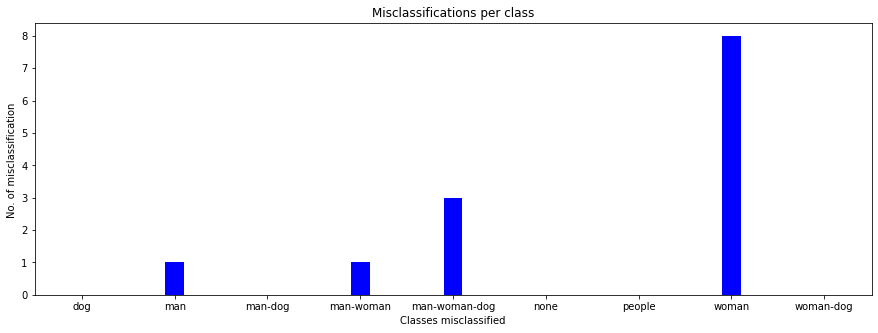

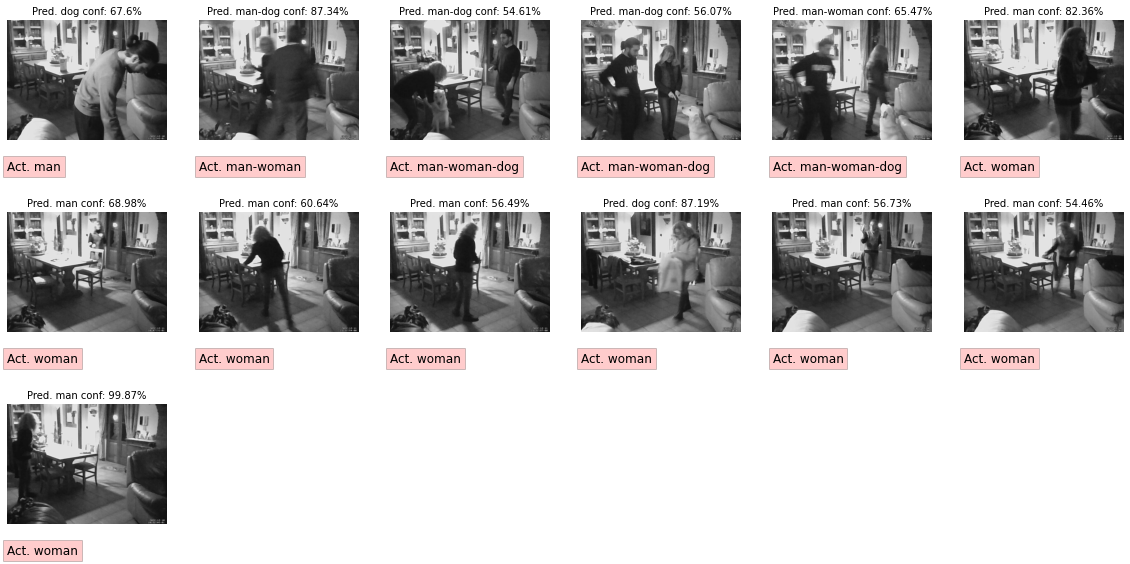

In [ ]:
statErrors(test_dataset,predictions,False,True)

## Experiment 3: benefits of lots of data
In this section the previous models structures are reused in order to analyse the training behaviour considering a reduced portion of the initial dataset. The notebook nr 1 is repeated in order to create a balanced subset of the entire dataset. This dataset is contained in subfolder in folder *dataset2*. This is a non-common practice because not always who wants to train a deep neural network has a lot of data to work with. The task to be resolved is  generally more difficult than the task proposed in this project and situations of  overfitting or underfitting have to be fight. For this reason, this part is proposed just to have a confirmation of the benefits obtained from the all-available data.

In [ ]:
BASE_PATH='/content/drive/MyDrive/CIDL/'

In [ ]:
NEW_PATH=os.path.join(BASE_PATH,'dataset2')

NEW_PATH_TRAIN=os.path.join(NEW_PATH,'train')
NEW_PATH_VALIDATION=os.path.join(NEW_PATH,'validation')
NEW_PATH_TEST=os.path.join(NEW_PATH,'test')

In [ ]:
train_dataset = image_dataset_from_directory(
    NEW_PATH_TRAIN,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
    )
validation_dataset = image_dataset_from_directory(
    NEW_PATH_VALIDATION,
    label_mode='categorical',
    image_size=(480, 640),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
    )
test_dataset = image_dataset_from_directory(
    NEW_PATH_TEST,
    label_mode='categorical',
    image_size=(480, 640),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=False,
    #validation_split = 0.2,
    #subset = "validation",
    #seed = 1
   )

Found 450 files belonging to 9 classes.
Found 90 files belonging to 9 classes.
Found 3960 files belonging to 9 classes.


Here are reported the results obtained using this configuration on the simple model (using Adam optimizer) and the deeper model (with 3 convolutional layers, using LeakyReLU as activation function).

### Simple model

In [ ]:
#Istantiate the model
model=createModelExp1()

#Define a callback
custom_callback=createCustomCallbackExp1(os.path.join(MODEL_PATH, 'thirdCNNModel_1.h5'),'val_loss')

#Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 480, 640, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 480, 640, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 160, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                       

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history3_1Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 2.0528 - accuracy: 0.2467
Epoch 1: val_loss improved from inf to 1.45853, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_1.h5
15/15 [==============================] - 240s 8s/step - loss: 2.0528 - accuracy: 0.2467 - val_loss: 1.4585 - val_accuracy: 0.5222
Epoch 2/50
14/15 [===========================>..] - ETA: 0s - loss: 1.2259 - accuracy: 0.5513
Epoch 2: val_loss improved from 1.45853 to 0.92867, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_1.h5
15/15 [==============================] - 4s 232ms/step - loss: 1.2273 - accuracy: 0.5489 - val_loss: 0.9287 - val_accuracy: 0.7000
Epoch 3/50
14/15 [===========================>..] - ETA: 0s - loss: 0.7917 - accuracy: 0.7210
Epoch 3: val_loss improved from 0.92867 to 0.68702, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_1.h5
15/15 [==============================] - 3s 177ms/step - loss: 0.7932 - accuracy: 0.7200 - val_

In [ ]:
#Load the best obtained with low loss epoch 10
model = load_model(MODEL_PATH+"/thirdCNNModel_1.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

124/124 [==============================] - 12s 92ms/step - loss: 0.2670 - accuracy: 0.9207


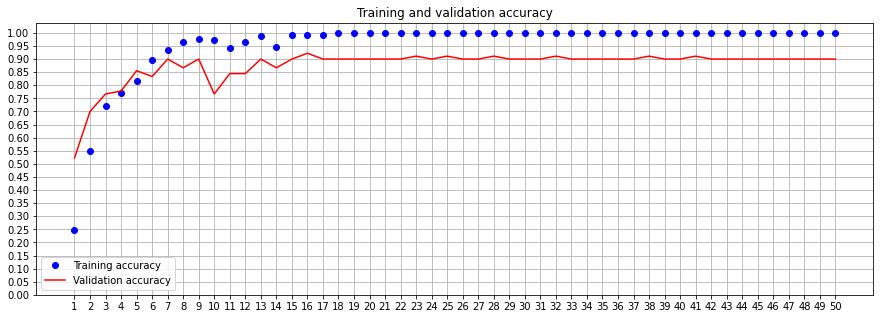

<Figure size 432x288 with 0 Axes>

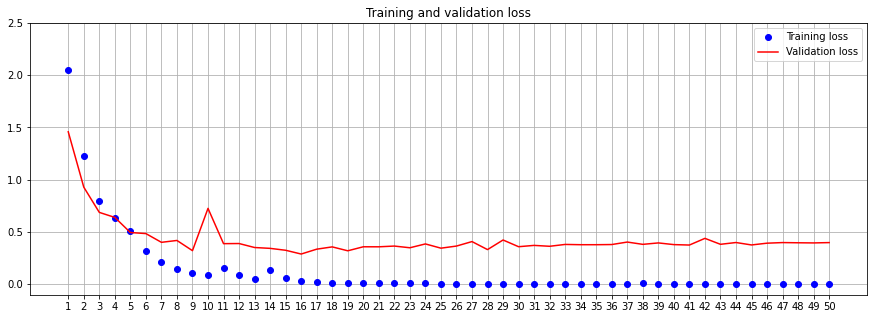

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history3_1Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 3, 0.5))

In [ ]:
#In this case more error are present.. 
#statErrors(test_dataset,predictions,False,True)

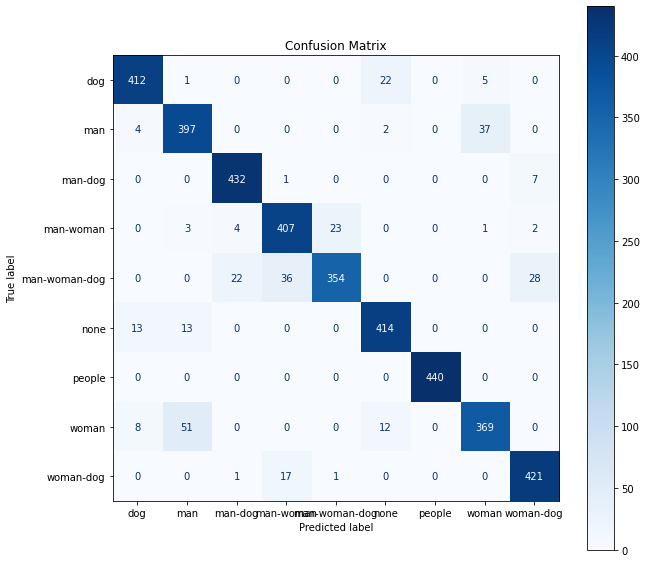

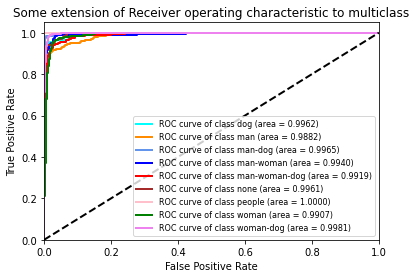

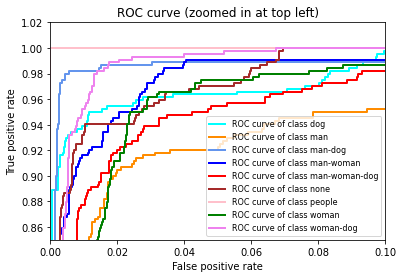

In [ ]:
evalutation_performance(test_dataset,predictions,0.85)

### Deeper model

In [ ]:
#Istantiate the model
model=createModelExp2_2()

#Define a callback
custom_callback=createCustomCallbackExp1(os.path.join(MODEL_PATH, 'thirdCNNModel_2.h5'),'val_loss')

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 480, 640, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 480, 640, 32)      320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 480, 640, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 160, 64)      18496     
                                                           

In [ ]:
#Start training 
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks = custom_callback
)
#Save history obtained in history folder
with open(HISTORY_PATH+'/history3_2Dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 2.1387 - accuracy: 0.2244
Epoch 1: val_loss improved from inf to 1.89783, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_2.h5
15/15 [==============================] - 68s 2s/step - loss: 2.1387 - accuracy: 0.2244 - val_loss: 1.8978 - val_accuracy: 0.3444
Epoch 2/50
14/15 [===========================>..] - ETA: 0s - loss: 1.5083 - accuracy: 0.4397
Epoch 2: val_loss improved from 1.89783 to 1.15371, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_2.h5
15/15 [==============================] - 4s 206ms/step - loss: 1.5046 - accuracy: 0.4422 - val_loss: 1.1537 - val_accuracy: 0.5556
Epoch 3/50
14/15 [===========================>..] - ETA: 0s - loss: 0.8688 - accuracy: 0.6719
Epoch 3: val_loss improved from 1.15371 to 0.79891, saving model to /content/drive/MyDrive/CIDL/models/thirdCNNModel_2.h5
15/15 [==============================] - 3s 194ms/step - loss: 0.8701 - accuracy: 0.6711 - val_l

In [ ]:
#Load the best obtained with low loss epoch 10
model = load_model(MODEL_PATH+"/thirdCNNModel_2.h5") 
predictions = model.predict(test_dataset) # get the output for each sample
test_loss, test_acc = model.evaluate(test_dataset)

124/124 [==============================] - 12s 94ms/step - loss: 0.3057 - accuracy: 0.9033


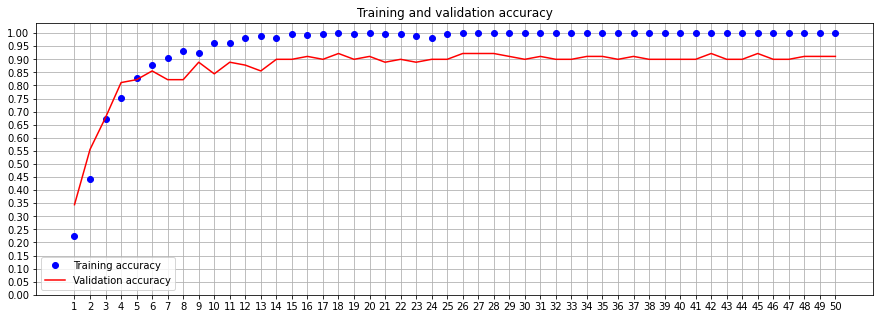

<Figure size 432x288 with 0 Axes>

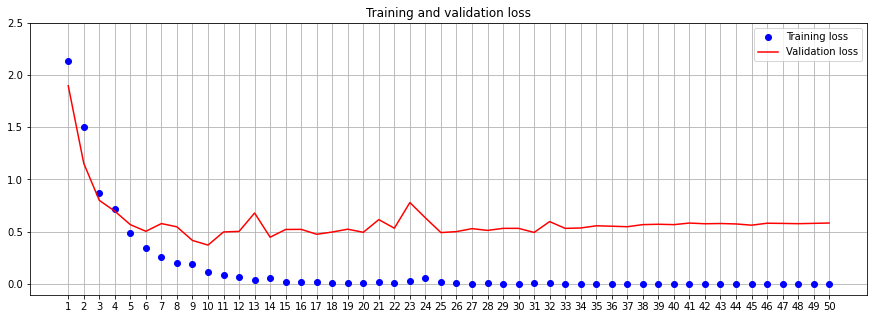

In [ ]:
#Reload the history in a further moment and plot the graphics

with open(HISTORY_PATH+'/history3_2Dict', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
  
plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 1),np.arange(0, 1+0.05, 0.05),np.arange(1, EPOCHS+1, 1),np.arange(0, 3, 0.5))

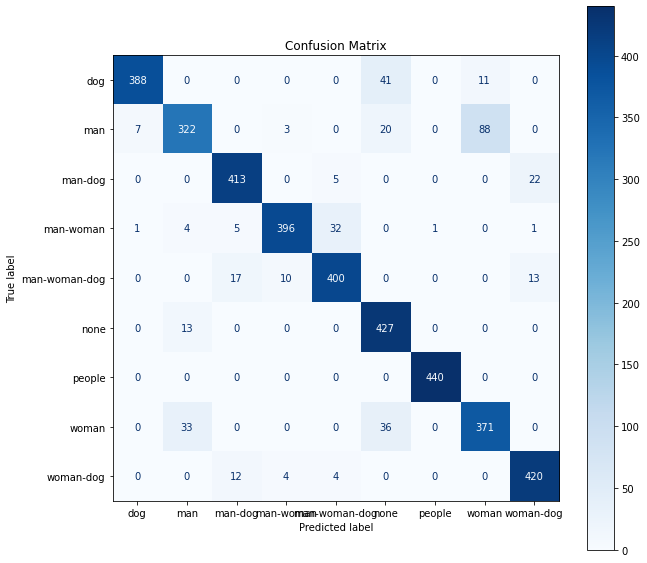

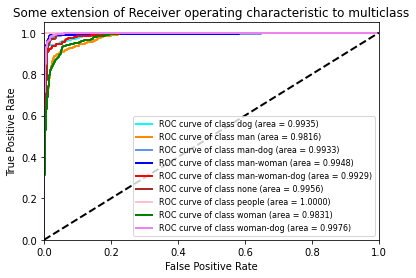

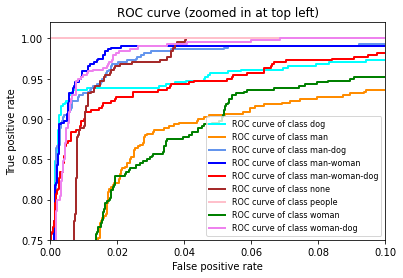

In [ ]:
evalutation_performance(test_dataset,predictions,0.75)

In both the cases the phenomenon of overfitting is present. These two models have lower generalization capabilities respect to the model trained before. In a situation where no more data can be obtained, operations like dataset augmentation, reducing the capacity of the network, adding weight regularization or adding dropout layer can be done to reduce it.

The great advantage of having a large number of data is to build simpler models that require less memory and less time to be trained but also to solve the overfitting phenomenon in a natural way.